In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, DataLoader
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

In [26]:
def mirror_and_filter(image):
    mirrored_image = cv2.flip(image, 1)
    
    filtered_image = cv2.bitwise_not(mirrored_image)
    
    return filtered_image

def process_images(folder, label):
    images = []
    paths = []
    
    for filename in os.listdir(folder):
        path = os.path.join(folder, filename)
        if os.path.isfile(path):
            image = cv2.imread(path)
            if image is not None:
                processed_image = mirror_and_filter(image)
                images.append(processed_image)
                paths.append(path)
    
    return images, paths

In [16]:
def main():
    defected_folder = "defected"
    no_defected_folder = "no_defected"
    
    mirror_defected_folder = "mirror_defected"
    mirror_no_defected_folder = "mirror_no_defected"
    
    os.makedirs(mirror_defected_folder, exist_ok=True)
    os.makedirs(mirror_no_defected_folder, exist_ok=True)
    
    defected_images, defected_paths = process_images(defected_folder, 'bad')
    for i, image in enumerate(defected_images):
        new_path = os.path.join(mirror_defected_folder, "mirror_" + os.path.basename(defected_paths[i]))
        cv2.imwrite(new_path, image)
    
    no_defected_images, no_defected_paths = process_images(no_defected_folder, 'good')
    for i, image in enumerate(no_defected_images):
        new_path = os.path.join(mirror_no_defected_folder, "mirror_" + os.path.basename(no_defected_paths[i]))
        cv2.imwrite(new_path, image)
    
    paths = np.concatenate((defected_paths, no_defected_paths), axis=0)
    labels = ['bad'] * len(defected_paths) + ['good'] * len(no_defected_paths)
    
    mirror_paths = []
    for folder in [mirror_defected_folder, mirror_no_defected_folder]:
        for filename in os.listdir(folder):
            path = os.path.join(folder, filename)
            if os.path.isfile(path):
                mirror_paths.append(path)
                labels.append('bad' if folder == mirror_defected_folder else 'good')
    
    paths = np.concatenate((paths, mirror_paths), axis=0)
    
    df = pd.DataFrame({'path': paths, 'label': labels})
    
    cols = list(df.columns)
    cols = ['path', 'label'] + cols[:-2]
    df = df[cols]
    
    df.to_csv("processed_dataset.csv", index=False)
    
    print("Датасет сохранен в файл processed_dataset.csv")

if __name__ == "__main__":
    main()

Датасет сохранен в файл processed_dataset.csv


In [27]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [28]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx, 0]
        img_path = os.path.join(self.root_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        label = self.data.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, label

In [29]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [30]:
csv_file = "processed_dataset.csv"
root_dir = "E:/umnojaya_talants/"

all_dataset = CustomDataset(csv_file=csv_file, root_dir=root_dir, transform=transform)

train_size = int(0.8 * len(all_dataset))
test_size = len(all_dataset) - train_size
train_dataset, test_dataset = random_split(all_dataset, [train_size, test_size])

In [31]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [32]:
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [33]:
def train(model, train_loader, criterion, optimizer, epochs=10):
    losses = []
    for epoch in range(1, epochs + 1):
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            labels_numeric = [1 if label == 'good' else 0 for label in labels]
            labels_tensor = torch.tensor(labels_numeric, dtype=torch.long)
            loss = criterion(outputs, labels_tensor)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        losses.append(epoch_loss)
        print(f'Epoch [{epoch}/{epochs}], Loss: {epoch_loss:.4f}')
    
    plt.plot(range(1, epochs + 1), losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()

Epoch [1/12], Loss: 0.6269
Epoch [2/12], Loss: 0.3196
Epoch [3/12], Loss: 0.1782
Epoch [4/12], Loss: 0.1280
Epoch [5/12], Loss: 0.0989
Epoch [6/12], Loss: 0.0706
Epoch [7/12], Loss: 0.0601
Epoch [8/12], Loss: 0.0522
Epoch [9/12], Loss: 0.0457
Epoch [10/12], Loss: 0.0446
Epoch [11/12], Loss: 0.0392
Epoch [12/12], Loss: 0.0350


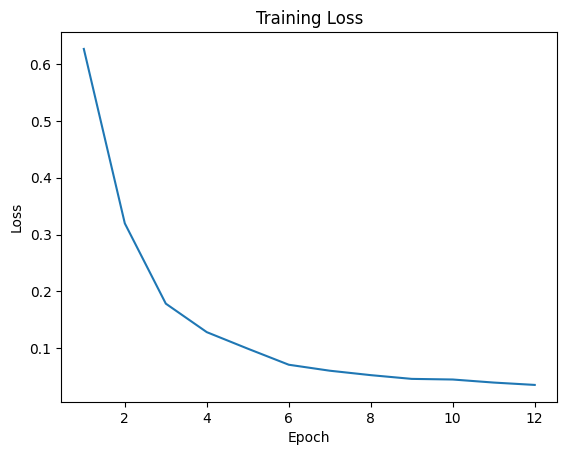

In [34]:
train(model, train_loader, criterion, optimizer, epochs=12)

In [35]:
from PIL import Image
import torchvision.transforms as transforms

def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    image = Image.open(image_path).convert('RGB')
    image = transform(image)
    image = image.unsqueeze(0)
    return image


def show_image_with_label(image_path, label):
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.title(f'Prediction: {label}')
    plt.show()


def predict_image(model, image):
    model.eval()
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
        label = 'good' if predicted.item() == 1 else 'bad'
    return label




In [36]:
from sklearn.metrics import f1_score

def predict_images(model, dataloader):
    model.eval()
    true_labels = []
    predicted_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            labels = [1 if label == 'good' else 0 for label in labels]
            true_labels.extend(labels)
            predicted_labels.extend(predicted.cpu().numpy())
    return true_labels, predicted_labels

true_labels, predicted_labels = predict_images(model, test_loader)
f1 = f1_score(true_labels, predicted_labels, average='weighted')
print(f'F1-score: {f1}')

F1-score: 0.9839486356340289


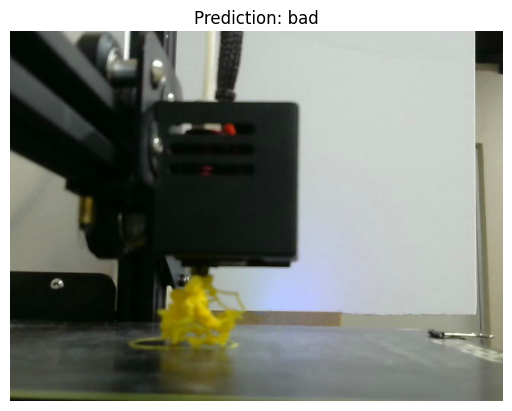

The model predicts: bad


In [38]:
image_path = "defected/leg_broken_7.jpg"
image = preprocess_image(image_path)
prediction = predict_image(model, image)
show_image_with_label(image_path, prediction)
print(f'The model predicts: {prediction}')

In [118]:
torch.save(model.state_dict(), "defect_detection_model.pth")